In [1]:
import matplotlib.pyplot as plt
from gerrychain import (GeographicPartition, Graph, MarkovChain,
                        updaters, constraints, accept, Election)
from gerrychain.proposals import recom
from functools import partial
import numpy as np

In [2]:
g = Graph.from_file("./NY-lab/NY.shp")

NUM_DISTRICTS = 26

/Users/y.solomon/opt/anaconda3/envs/gerry/lib/python3.12/site-packages/gerrychain/graph/graph.py:274: UserWarning: Found islands (degree-0 nodes). Indices of islands: {134451, 134452}
  warnings.warn(
/Users/y.solomon/opt/anaconda3/envs/gerry/lib/python3.12/site-packages/gerrychain/graph/graph.py:179: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


In [3]:
# graph = g.copy()

In [23]:
elections = [
    Election("PRES20", {"Democratic": "G20PRED", "Republican": "G20PRER"}),
]

my_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

In [24]:
# initial_partition = GeographicPartition(g, assignment= "CD", updaters=my_updaters)
initial_partition = GeographicPartition(g, assignment= "CD", updaters=my_updaters)

In [25]:
ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)
print(ideal_population)

776971.1153846154


In [26]:
proposal = partial(recom,
                   pop_col="TOTPOP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

In [27]:
chain = MarkovChain(
      proposal=proposal,
      constraints=[
            pop_constraint,
            compactness_bound,
      ],
      accept=accept.always_accept,
      initial_state=initial_partition,
      total_steps=3000
      )

In [28]:
pres_buckets = [[] for _ in range(NUM_DISTRICTS)] # make one bucket per district

In [29]:
for state in chain:
  pres_dem_percents = sorted(state["PRES20"].percents("Democratic"))
  
  for i in range(NUM_DISTRICTS):
    pres_buckets[i].append(pres_dem_percents[i])

[]

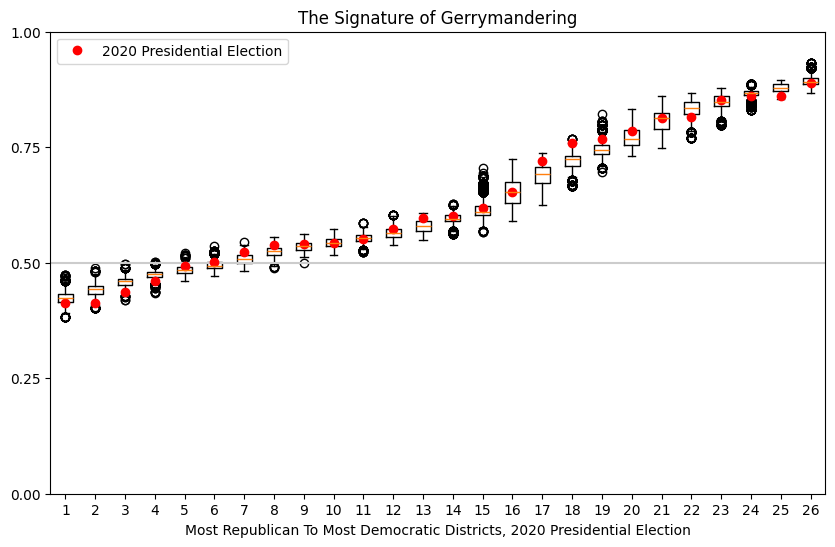

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(pres_buckets, vert=True)

ax.axhline(0.5, color="#cccccc")

# Set the title and labels
ax.set_title('The Signature of Gerrymandering')
ax.set_xlabel('Most Republican To Most Democratic Districts, 2020 Presidential Election')
plt.plot([None] + sorted(initial_partition["PRES20"].percents("Democratic")), "ro", label="2020 Presidential Election")

ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.legend()

plt.savefig('./box_plots/PRES20_box_plot_3000.png')

plt.plot()